In [1]:
import numpy as np
import matplotlib.pyplot as plt
import exoplanet as xo
from scipy.interpolate import interp1d
from matplotlib.widgets import Slider, Button

import math
import lightkurve as lk
from astropy.io import fits

In [2]:
search_result = lk.search_tesscut('koi-3678', sector=54)
search_result


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 54,2022,TESScut,475,koi-3678,0.0


In [3]:
tpf = []
for sr in search_result:
    tpf.append(sr.download(cutout_size=(8,8)))

target_mask = []
for a_tpf in tpf:
    target_mask.append(a_tpf.create_threshold_mask(threshold=3, reference_pixel='center'))
    

n_target_pixels = []
for a_target_mask in target_mask: 
    n_target_pixels.append(a_target_mask.sum())
    
    
n_target_pixels


[4]

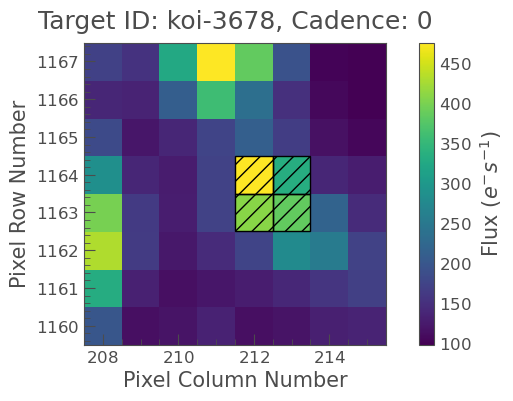

In [4]:
for ii in range(0, len(tpf)):
    a_tpf = tpf[ii]
    a_target_mask = target_mask[ii]
    
    
    a_tpf.plot(aperture_mask=a_target_mask, mask_color='k')
    plt.savefig('koi3678_aperture.pdf')
    plt.show()


In [5]:
a_tpf.to_lightcurve(aperture_mask=a_target_mask)

time,flux,flux_err,centroid_col,centroid_row,cadenceno,quality
,electron / s,electron / s,pix,pix,,
Time,float32,float32,float64,float64,int64,int32
2769.9089106980873,1664.006103515625,2.059659481048584,212.43198924068582,1163.523175998189,0,0
2769.9158552797253,1657.2066650390625,2.055976152420044,212.4337571782867,1163.5244361360556,1,0
2769.9227998608967,1654.86181640625,2.0543413162231445,212.4336618220991,1163.522158496936,2,0
2769.929744441836,1659.15625,2.0585896968841553,212.4321480997966,1163.5233124614474,3,0
2769.9366890223096,1660.3760986328125,2.0567753314971924,212.43266513015445,1163.5243767351103,4,0
2769.943633602551,1662.091552734375,2.0611002445220947,212.4324852484464,1163.5235459707485,5,0
2769.9505781823264,1658.8355712890625,2.0564680099487305,212.4340676233542,1163.5238871275612,6,0
2769.957522761634,1660.050537109375,2.0579521656036377,212.4345511449479,1163.5237647853164,7,0


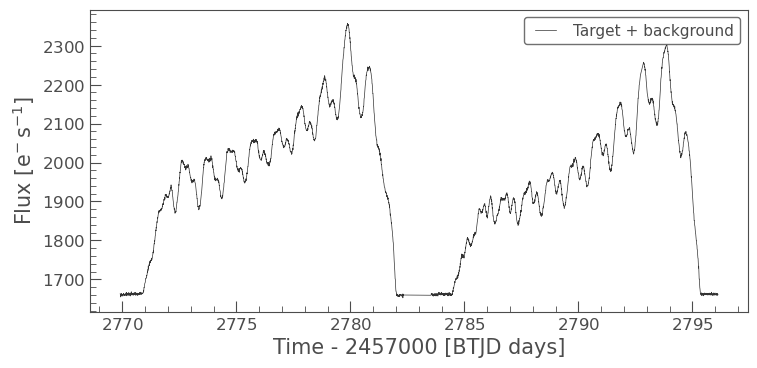

In [6]:
target_lc = []
for ii in range(0, len(tpf)):
    a_tpf = tpf[ii]
    a_target_mask = target_mask[ii]
    
    target_lc.append(a_tpf.to_lightcurve(aperture_mask=a_target_mask))
    
    
    target_lc[ii].plot(label='Target + background');
    


[32]

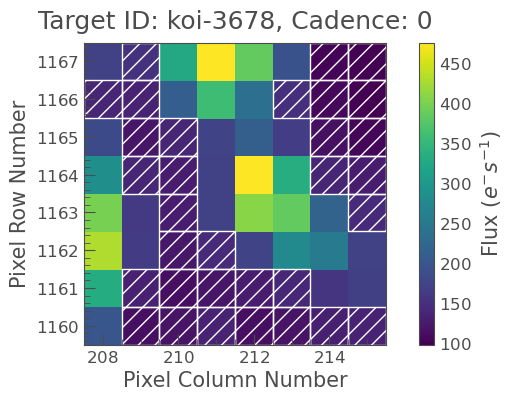

In [7]:
background_mask = []
n_background_pixels = []
for ii in range(0, len(tpf)):
    a_tpf = tpf[ii]
    
    background_mask.append(~a_tpf.create_threshold_mask(threshold=0.0001, reference_pixel=None))
    
    a_tpf.plot(aperture_mask=background_mask[ii], mask_color='w')
    plt.savefig('koi3678_aperture_background.pdf')
    
    n_background_pixels.append(background_mask[ii].sum())

    
    
n_background_pixels



We identified 32 “empty” pixels that could be suitable for estimating the background. The 20x20 cutout has 400 pixels, so these 32 pixels are roughly the pixels with fluxes below the median.

One may object that these ostensibly empty pixels contain background stars, so there is some uncertain zero-point level from imperfect background estimation. That’s true! Background estimation is ultimately a challenge for working with TESS cutouts, especially since background varies in both space and time. Such effects should diminish as your background model approaches reality by modeling or ignoring known background sources and as more instrumental characterization proceeds. The Gaia background sources can be examined using .interact_sky():

In [8]:
background_lc_per_pixel = []
for ii in range(0, len(tpf)):
    a_tpf = tpf[ii]
    a_background_mask = background_mask[ii]
    a_n_background_pixels= n_background_pixels[ii]
    
    
    background_lc_per_pixel.append(
        a_tpf.to_lightcurve(aperture_mask=a_background_mask) / a_n_background_pixels)


The amount of background seen in the target aperture is the background flux per pixel times the number of pixels in the target aperture.



In [9]:
background_estimate_lc = []
background_estimate_lc2 = []
for ii in range(0, len(tpf)):
    a_background_lc_per_pixel = background_lc_per_pixel[ii]
    a_n_target_pixels = n_target_pixels[ii]
    a_n_target_pixels2 = 3

    
    
    background_estimate_lc.append(a_background_lc_per_pixel * a_n_target_pixels)
    background_estimate_lc2.append(a_background_lc_per_pixel * a_n_target_pixels2)


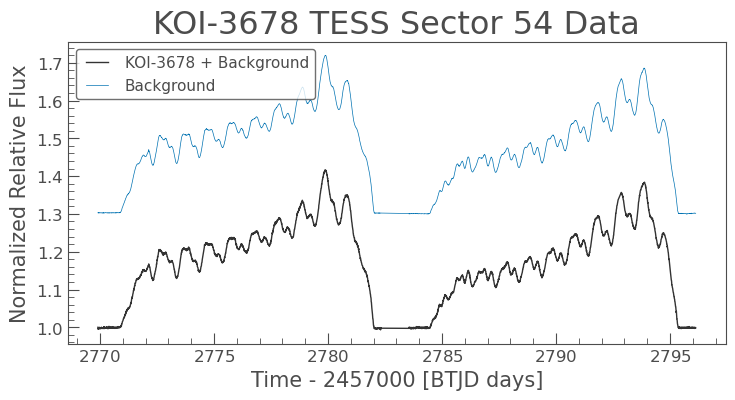

In [10]:
common_normalization = []
for ii in range(0, len(tpf)):
    a_target_lc = target_lc[ii]
    a_background_estimate_lc = background_estimate_lc[ii]
    a_background_lc_per_pixel = background_lc_per_pixel[ii]
    a_n_target_pixels = n_target_pixels[ii]
    
    
    a_common_normalization = np.nanpercentile(a_target_lc.flux, 10)
    common_normalization.append(a_common_normalization)
    
    ax = (a_target_lc / a_common_normalization).plot(normalize=False, label='KOI-3678 + Background', lw=1);
    (a_background_estimate_lc / a_common_normalization +1).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized Relative Flux');
    
    
    plt.title('KOI-3678 TESS Sector 54 Data', fontsize=23)
    plt.savefig('koi3678_tess_rawLC.pdf')


In [11]:
epoch = 2456397.578 - 2457000

kepler_epochs = []
for ii in range (0, 50):
    epoch += 160.8845
    kepler_epochs.append(epoch)
    
    
    

epoch = 2456397.578 - 2457000
all_epochs = []
for ii in range (0, 50):
    epoch += 160.8845
    all_epochs.append(epoch)

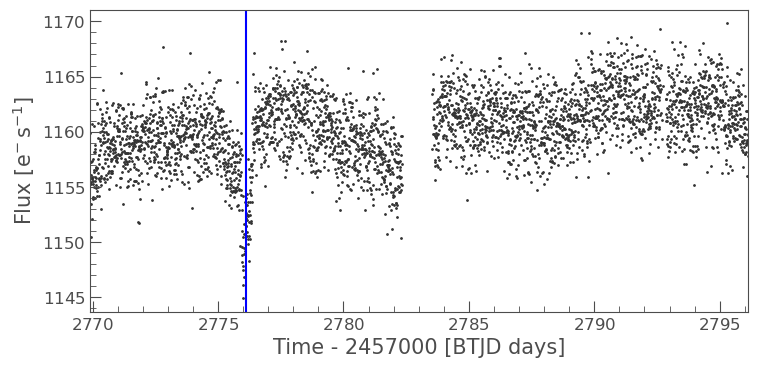

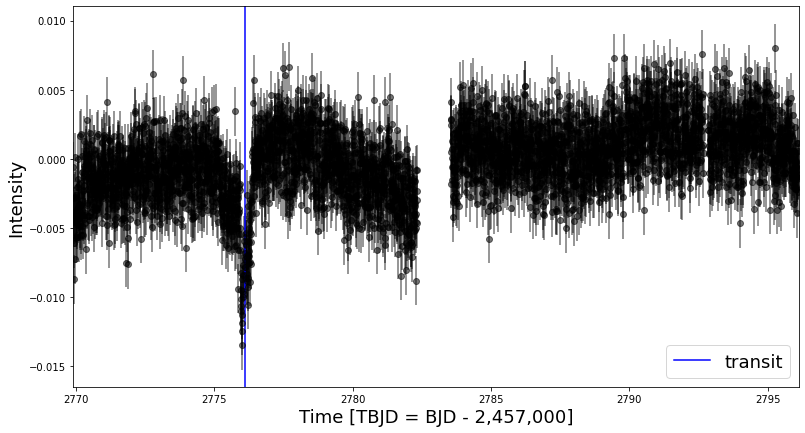

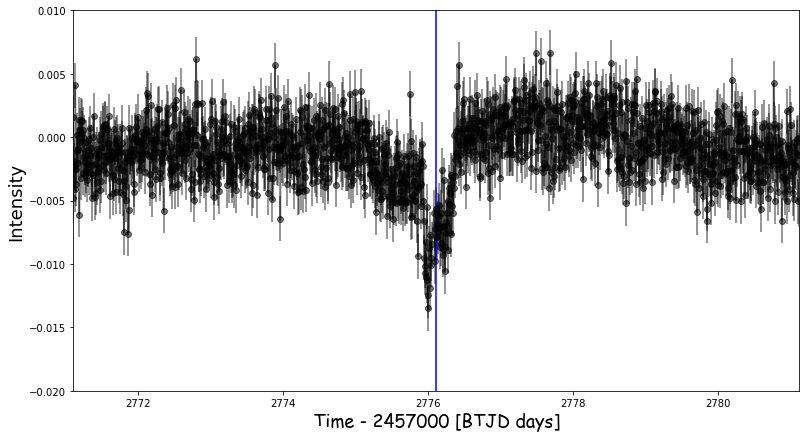

In [12]:
corrected_lc = []
x = []
y = []
yerr = []
for ii in range(0, len(tpf)):
    a_target_lc = target_lc[ii]
    a_background_estimate_lc = background_estimate_lc[ii]
    
    corrected_lc.append(a_target_lc - a_background_estimate_lc.flux)
    
    x.append(corrected_lc[ii].time.value)
    mu = np.median( corrected_lc[ii].flux.value )
    y.append( corrected_lc[ii].flux.value / mu - 1 )
    yerr.append( corrected_lc[ii].flux_err.value[ii] / mu )
    
    
    ax = corrected_lc[ii].scatter();
    
    plt.axvline(2459776.11-2457000, 0, 1, color = 'b', label='Kepler + BARO + BARON linear ephemeris')
    
    
    plt.xlim(np.min(corrected_lc[ii].time.value), np.max(corrected_lc[ii].time.value))
    plt.show()
    
    
    
    
    
    
    
    
    plt.figure(figsize=[13,7])
    plt.errorbar(x[ii], y[ii], yerr=yerr[ii], marker='o', alpha=0.54, color = 'k', ls='')
    plt.axvline(2459776.11-2457000, 0, 1, color = 'b', label='transit')
    
    
    plt.xlim(np.min(corrected_lc[ii].time.value), np.max(corrected_lc[ii].time.value))
    plt.xlabel('Time [TBJD = BJD - 2,457,000]', fontsize = 18)
    plt.ylabel('Intensity', fontsize = 18)
    plt.legend(fontsize=18, loc=4)
    
    plt.savefig('koi3678_tess_normalizedLC.pdf')
    plt.show()
    
    
    
    
    
    
    
    
    
    plt.figure(figsize=[13,7])
    plt.errorbar(x[ii], y[ii], yerr=yerr[ii], marker='o', alpha=0.54, color = 'k')
    plt.axvline(2459776.11-2457000, 0, 1, color = 'b', label='Kepler + BARO + BARON linear ephemeris')
    
    
    plt.xlim(2459776.11-2457000-5, 2459776.11-2457000+5)
    plt.ylim(-0.02, 0.01)
    plt.xlabel('Time - 2457000 [BTJD days]', fontname='Comic Sans MS', fontsize = 18)
    plt.ylabel('Intensity', fontsize = 18)
    plt.savefig('koi3678_tess_normalizedLC_transit.pdf')
    plt.show()
    
    




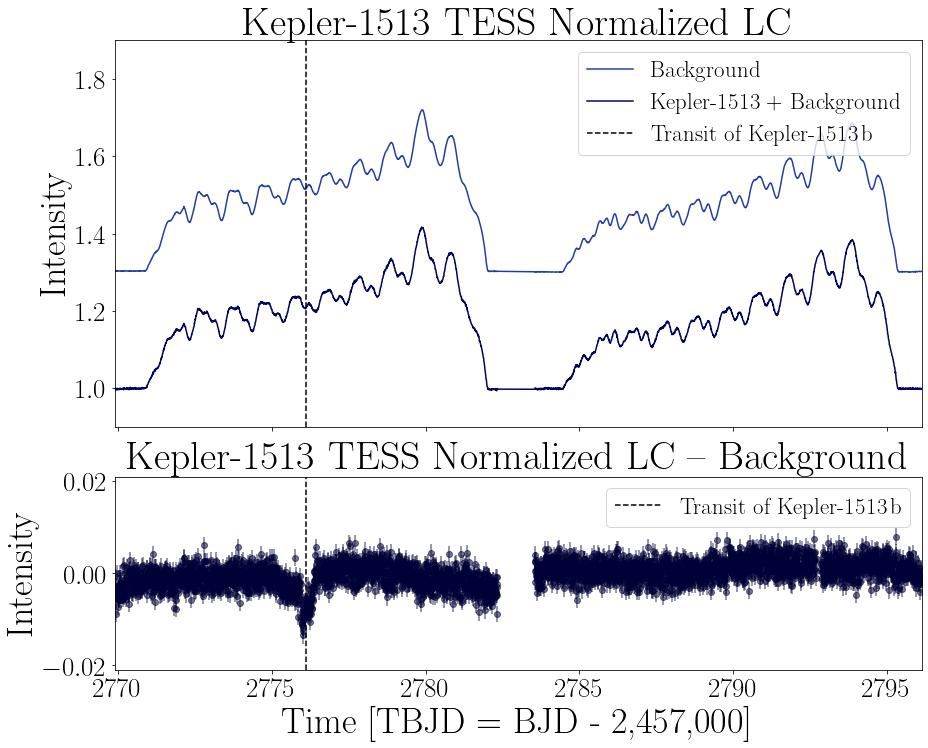

In [78]:
import matplotlib 
matplotlib.rc('xtick', labelsize=27) 
matplotlib.rc('ytick', labelsize=27) 
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

colors = ["#253DA1",
"#02055A",
"#000137"]

common_normalization = []
for ii in range(0, len(tpf)):
    a_target_lc = target_lc[ii]
    a_background_estimate_lc = background_estimate_lc[ii]
    a_background_lc_per_pixel = background_lc_per_pixel[ii]
    a_n_target_pixels = n_target_pixels[ii]
    
    

    a_common_normalization = np.nanpercentile(a_target_lc.flux, 10)
    common_normalization.append(a_common_normalization)
    
    fig, ax = plt.subplots(2,1,figsize=[13,10.5], sharex=True, gridspec_kw={'height_ratios': [2, 1]})
    
    ax[0].plot(a_target_lc.time.value, a_background_estimate_lc.flux.value/a_common_normalization.value+1,
              label='Background', color=colors[0])
    ax[0].plot(a_target_lc.time.value, a_target_lc.flux.value/a_common_normalization.value, 
               label='Kepler-1513 + Background', color=colors[1])
    ax[0].axvline(2459776.11-2457000, 0, 1, color='k', label=r'Transit of Kepler-1513\,b', ls='--')
    
    
    
    ax[1].errorbar(x[ii], y[ii], yerr=yerr[ii], marker='o', alpha=0.54, color=colors[2], ls='')
    ax[1].axvline(2459776.11-2457000, 0, 1, color='k', label=r'Transit of Kepler-1513\,b', ls='--')
     
    ax[0].set_ylim(0.9, 1.9)
    ax[1].set_ylim(-0.021, 0.021)
    ax[1].set_xlim(np.min(corrected_lc[ii].time.value), np.max(corrected_lc[ii].time.value))
    ax[1].set_xlabel('Time [TBJD = BJD - 2,457,000]', fontsize = 36)
    ax[0].set_ylabel('Intensity', fontsize = 36)
    ax[1].set_ylabel('Intensity', fontsize = 36)
    
    ax[0].legend(fontsize=23, loc=1)
    ax[1].legend(fontsize=23, loc=1)

    
    
    
    ax[0].set_title('Kepler-1513 TESS Normalized LC', fontsize=40)
    ax[1].set_title(r'Kepler-1513 TESS Normalized LC -- Background', fontsize=40)
    
    plt.tight_layout()
    plt.savefig('koi3678_tess_LC_all.pdf')


(2774.1099999998696, 2778.1099999998696)

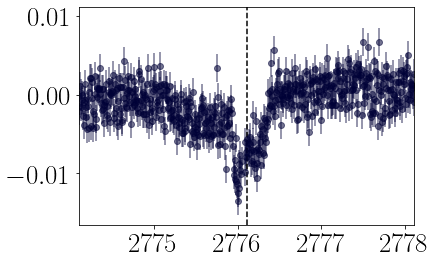

In [14]:
plt.errorbar(x[ii], y[ii], yerr=yerr[ii], marker='o', alpha=0.54, color=colors[2], ls='')
plt.axvline(2459776.11-2457000, 0, 1, color='k', label='transit', ls='--')
 
    
plt.xlim(2459776.11-2457000-2, 2459776.11-2457000+2)

